In [2]:
from multidimvis_main import *

In [3]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)

In [4]:
#################################################################
#
#    SAMPLE SUP PPI NETWORK
#
#################################################################

rand_set = rd.sample(G.nodes(),1000)

G_sub = nx.subgraph(G,rand_set)

G_ = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


print(G_.number_of_nodes())
print(G_.number_of_edges())

# nx.write_edgelist(G,'subPPI_4testing.txt')
G=G_

606
1247


## Diagram (network distance, spring, global layout)

In [155]:
# NETWORK DISTANCE

dist_network2D = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network2D[(a[0],n)] = spl

In [156]:
# SPRING LAYOUT

posG_spring2D = nx.spring_layout(G, iterations = 50, dim = 2)
df_posG = pd.DataFrame(posG_spring2D).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

posG = posG_spring2D#_norm
dist_spring2D = {} 
for p1,p2 in it.combinations(G.nodes(),2):
    dist_spring2D[(p1,p2)] = (posG[p1][0]-posG[p2][0])**2 + (posG[p1][1]-posG[p2][1])**2

In [184]:
# GLOBAL LAYOUT

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1
min_dist = 0.01
metric = 'cosine'
lnr = 1 
nep = None

feature = 'RWRvis'
r = .9 
alpha = 1.0
A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
DM_rwr = FM_m
umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

posG = posG_complete_umap_rwr#_norm
dist_layout2D = {} 
for p1,p2 in it.combinations(G.nodes(),2):
    dist_layout2D[(p1,p2)] = (posG[p1][0]-posG[p2][0])**2 + (posG[p1][1]-posG[p2][1])**2
    #dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

In [185]:
d_plot_spring = {}
for spldist in range(1,int(max(dist_network2D.values()))):
    l_s = []
    for k, v in dist_network2D.items():
        if v == spldist:
            l_s.append(k)

    l_xy = []
    for nodes in l_s:
        try:
            dxy = dist_spring2D[nodes]
            l_xy.append(dxy)
        except:
            pass
    d_plot_spring[spldist] = l_xy
    
    
d_plot_layout = {}
for spldist in range(1,int(max(dist_network2D.values()))):
    l_s = []
    for k, v in dist_network2D.items():
        if v == spldist:
            l_s.append(k)

    l_xy = []
    for nodes in l_s:
        try:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        except:
            pass
    d_plot_layout[spldist] = l_xy

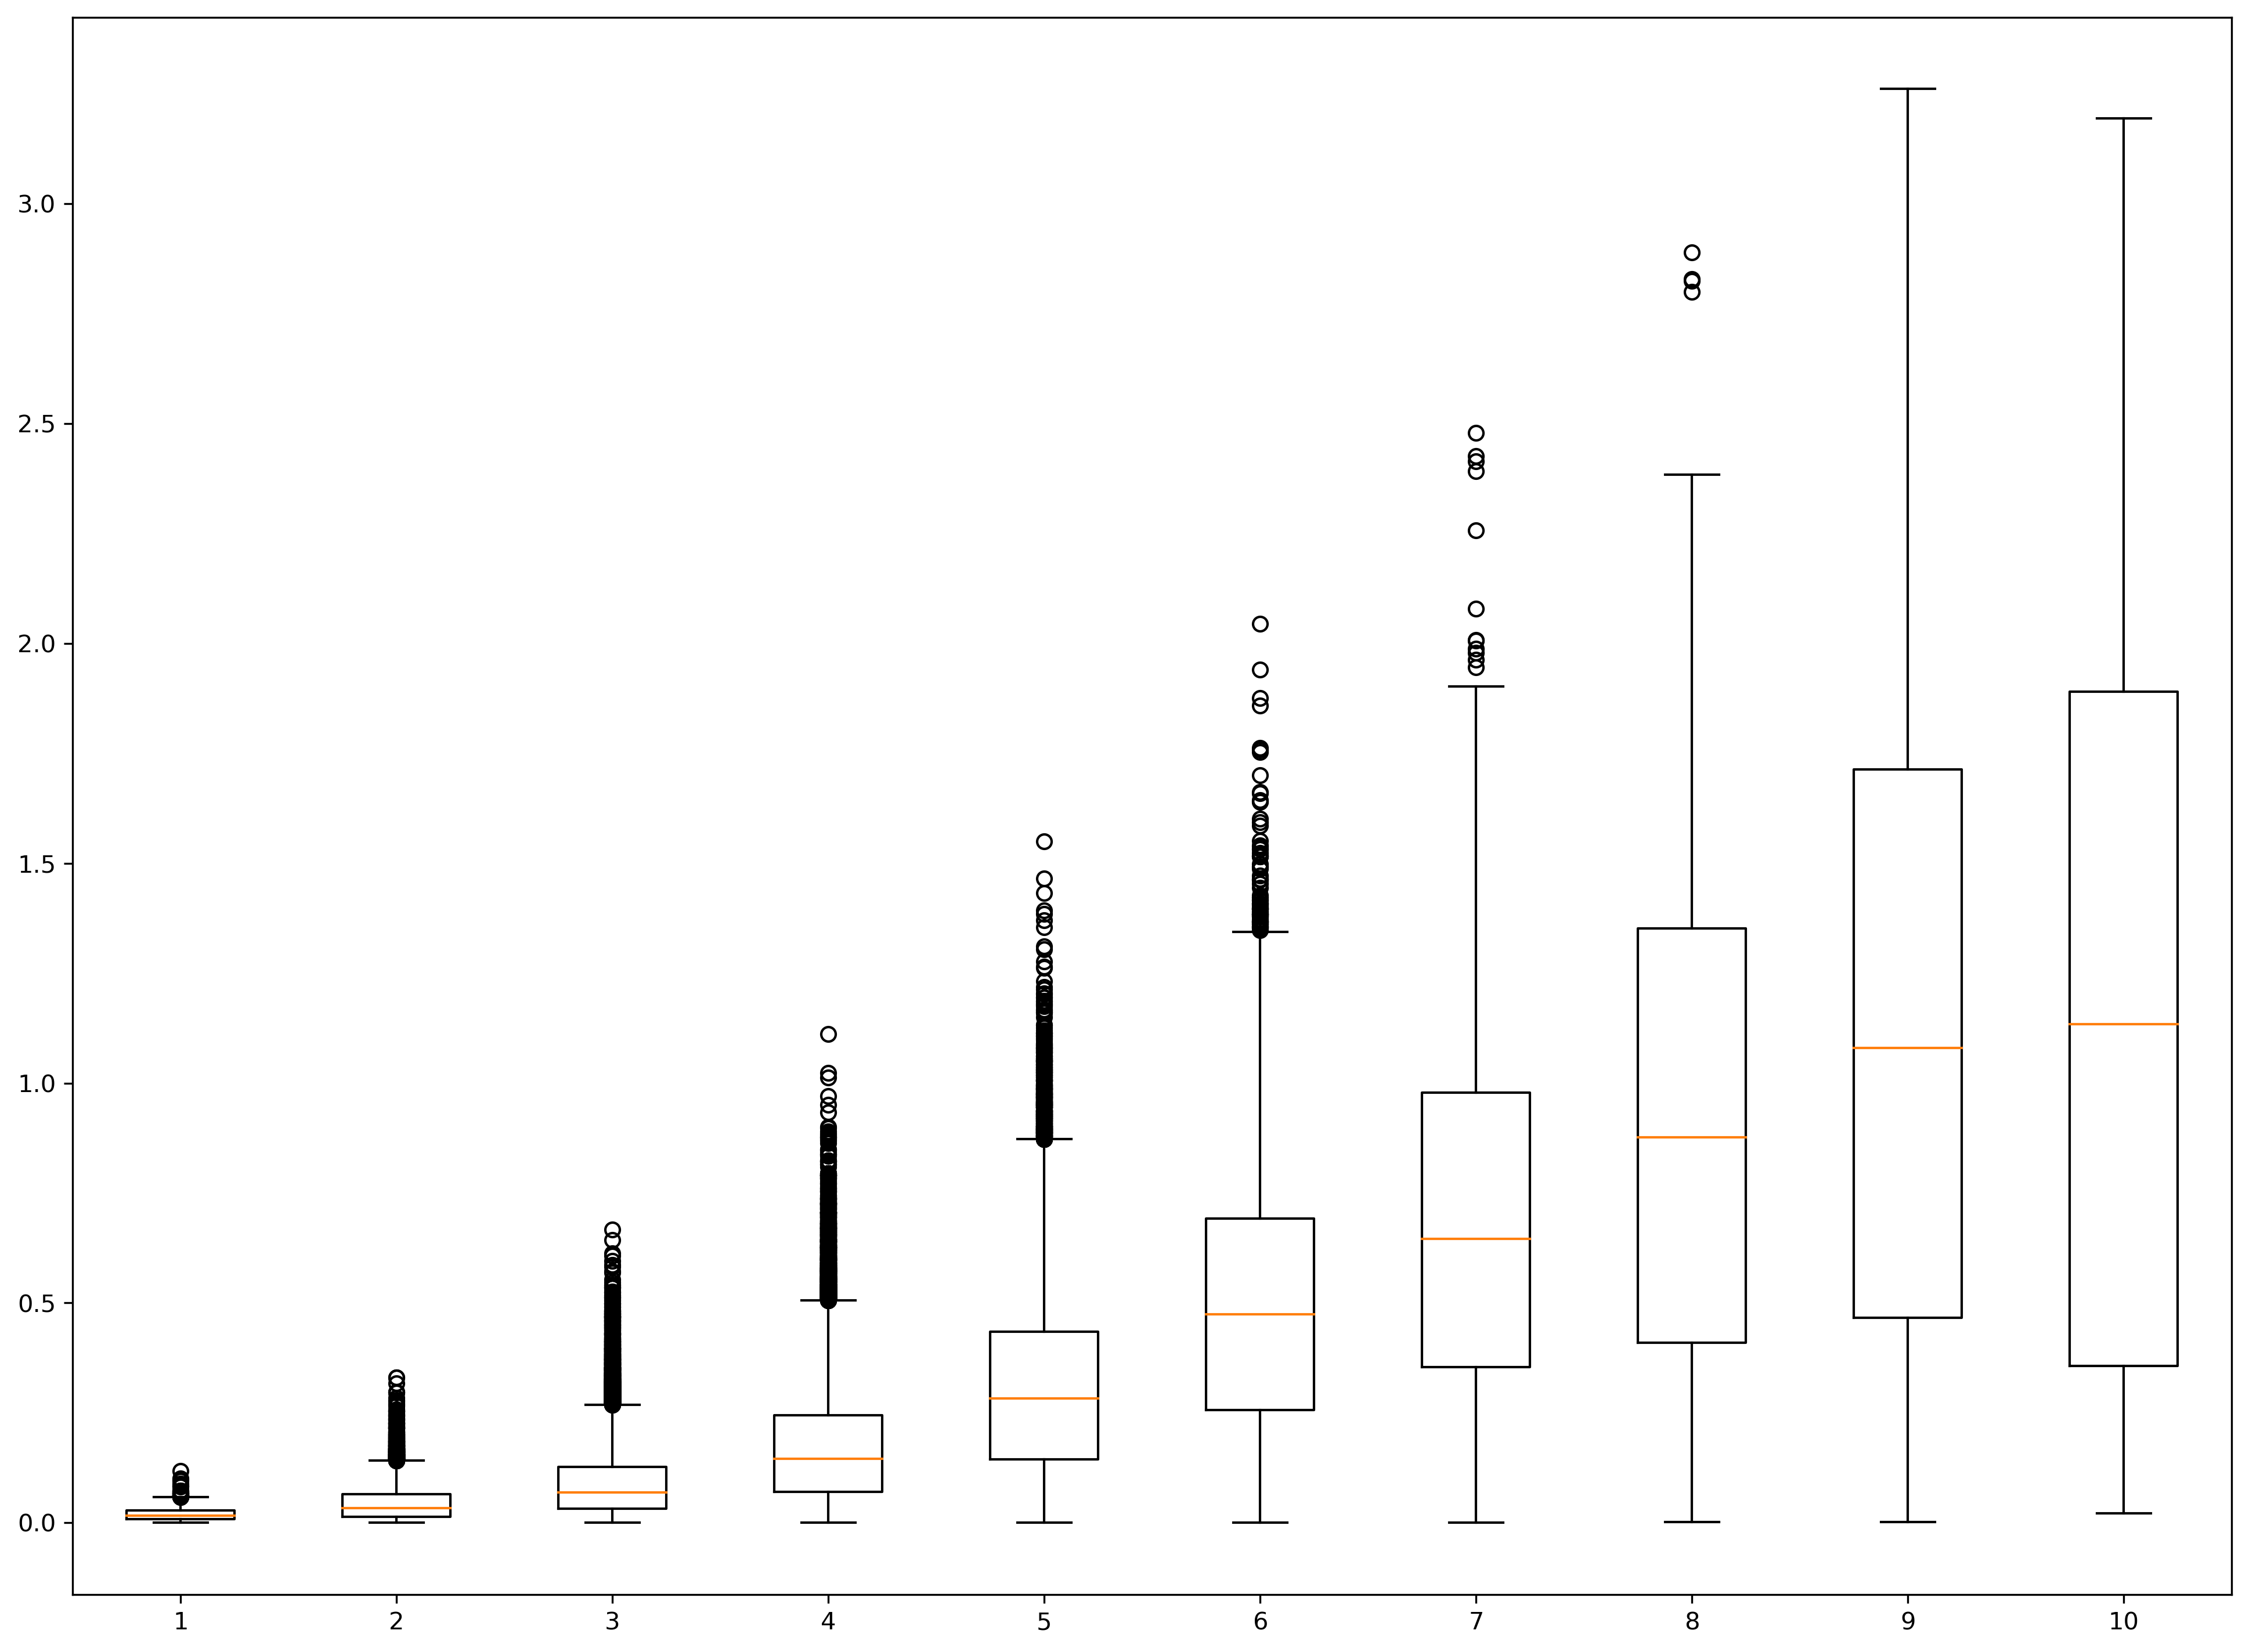

In [202]:
fig = plt.figure(figsize =(16,12), dpi=300)
labels, data = d_plot_spring.keys(), d_plot_spring.values()
plt.boxplot(data)
plt.xticks(range(1,len(labels)+1),labels)
plt.show()

## Pearson Correlation Coefficient

In [208]:
l_medians = []
for k, v in d_plot_spring.items():
    l_medians.append(statistics.median(v))
r = np.corrcoef(np.array(range(1,diameter)), np.array(l_medians))
print('Pearson correlation coefficient:', r[0][1])

Pearson correlation coefficient: 0.9740250296555493


In [209]:
l_medians = []
for k, v in d_plot_layout.items():
    l_medians.append(statistics.median(v))
r = np.corrcoef(np.array(range(1,diameter)), np.array(l_medians))
print('Pearson correlation coefficient:', r[0][1])

Pearson correlation coefficient: 0.987792777489364


In [102]:
#################################################################
#
#    Visiting probability based distances
#
##################################################################   

In [210]:
t0 = time.time()

r = .8
alpha = 1.
num_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,sorted(G.nodes()))

#################################################################
#
#    INVERT MARKOV MATRIX & GENERATE RW MATRIX
#
###################

W = rnd_walk_matrix(A, r, alpha, num_nodes)

print('Inversion done')

#################################################################
#
#    GENERATE DICT FOR NODE-LABELS TO INTEGERS
#
###################

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1
d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


print('computing time: %.2f' %float(time.time()-t0))

Inversion done
computing time: 0.06


In [211]:
d_pvis = {}
for a,b in it.combinations(G.nodes(),2):
    idx_a = d_entz_idx[a]
    idx_b = d_entz_idx[b]
    # print(idx_a)
    # print()
    # print(W[idx_a,idx_b])
    p_d =  min((W[idx_a,idx_b],W[idx_b,idx_a]))
    d_pvis[(a,b)] = -np.log(p_d)


In [212]:
# l_stacked_xy = np.zeros(100)
d_violin_p = {}
for dd in range(1,diameter):
    l_s = []
    for k, v in d_spl.items():
        if v == dd:
            l_s.append(k)

    l_pvis = []
    for ab in l_s:
        try:
            dp = d_pvis[ab]
            l_pvis.append(dp)
            # print(ab,dxy)
        except:
            pass
    # l_stacked_xy = np.vstack((l_stacked_xy,l_xy))
    d_violin_p["string{0}".format(dd)] = l_pvis


Text(0, 0.5, 'distribution of -log pvis distances')

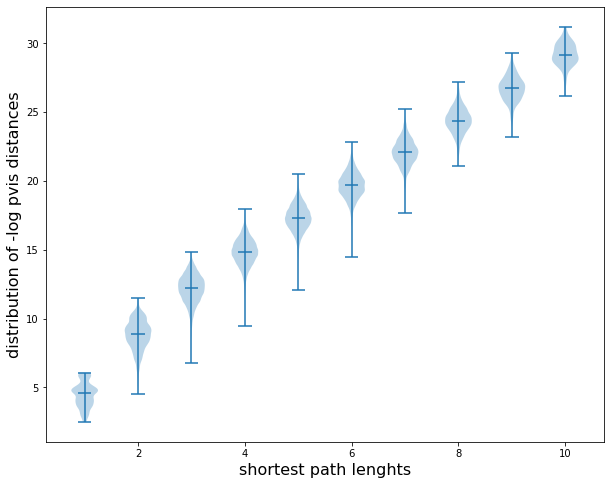

In [213]:
plt.figure(figsize=(10,8))
plt.violinplot(d_violin_p.values(), showmedians=True)
plt.xlabel('shortest path lenghts',fontsize = 16)
plt.ylabel('distribution of -log pvis distances',fontsize = 16)
# plt.savefig('spl_xy_N1000.png')


# --------------------------------------